Accuracy on test data is 100.0%
F1-score on test data is 100.0%
Accuracy for SGD on test data is 100.0%
F1-score for SGD on test data is 100.0%


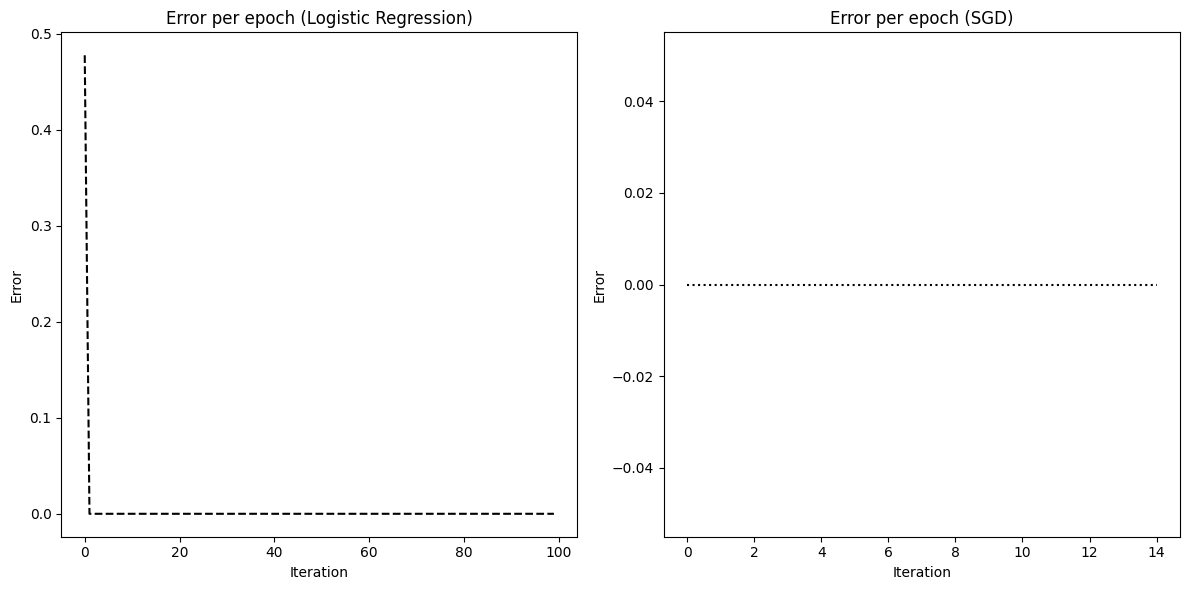

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from scipy import stats
from IPython.display import clear_output

# Constants
M , N = 250 , 200
np.random.seed(25)
my_ID_Number = 34
dataset_url = {
    'normal': 'https://engineering.case.edu/sites/default/files/99.mat',
    'faulty': 'https://engineering.case.edu/sites/default/files/107.mat'
}

# Functions
def load_data(url):
    !wget -q {url}
    return loadmat(url.split('/')[-1])

def organize_data(data_n, data_f, cols_n, cols_f):
    all_cols = np.concatenate((cols_n, cols_f))
    matrices = {}
    for col in all_cols:
        mat = np.zeros((M, N))
        for j in range(M):
            try:
                mat[j, :] = data_n[col][j:j+N].reshape(-1,)
            except:
                mat[j, :] = data_f[col][j:j+N].reshape(-1,)
        matrices[col] = mat
    return matrices

def extract_features(matrix):
    features = {
        'standard deviation': stats.tstd(matrix, axis=1),
        'peak': np.max(matrix, axis=1),
        'skewness': stats.skew(matrix, axis=1),
        'mean': np.mean(matrix, axis=1),
        'absolute mean': np.mean(np.abs(matrix), axis=1),
        'root mean square': np.sqrt(np.mean(np.square(matrix), axis=1)),
        'square root mean': np.square(np.mean(np.sqrt(np.abs(matrix)), axis=1)),
        'kurtosis': stats.kurtosis(matrix, axis=1),
        'crest factor': np.max(matrix, axis=1) / np.sqrt(np.mean(np.square(matrix), axis=1)),
        'clearance factor': np.max(matrix, axis=1) / np.square(np.mean(np.sqrt(np.abs(matrix)), axis=1)),
        'peak to peak': np.max(matrix, axis=1) - np.min(matrix, axis=1),
        'shape factor': np.sqrt(np.mean(np.square(matrix), axis=1)) / np.mean(np.abs(matrix), axis=1),
        'impact factor': np.sqrt(np.mean(np.square(matrix), axis=1)) / np.mean(np.abs(matrix), axis=1),
        'impulse factor': np.abs(np.mean(matrix, axis=1)) / np.mean(np.abs(matrix), axis=1)
    }
    return features

# Load datasets
data_n = load_data(dataset_url['normal'])
data_f = load_data(dataset_url['faulty'])
cols_n = list(data_n.keys())[-4:]
cols_f = list(data_f.keys())[-4:-1]

# Organize data into matrices
matrices = organize_data(data_n, data_f, cols_n, cols_f)

# Extract features for normal and fault datasets
normal_mat = matrices['X099_DE_time']
fault_mat = matrices['X107_DE_time']
normal_features = extract_features(normal_mat)
fault_features = extract_features(fault_mat)

# Create dataframes
df_normal = pd.DataFrame(normal_features)
df_normal['label'] = np.zeros((df_normal.shape[0],), dtype='int8')
df_fault = pd.DataFrame(fault_features)
df_fault['label'] = np.ones((df_fault.shape[0],), dtype='int8')

# Combine datasets
df = pd.concat([df_normal, df_fault], ignore_index=True)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1).values,
    df.label.values,
    test_size=0.2,
    shuffle=True,
    random_state=69
)

# Standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Logistic Regression Class
class LogisticRegression:
    def __init__(self, n_iter=10, learning_rate=0.01, random_state=None):
        self.n_iter = n_iter
        self.eta = learning_rate
        self.random_state = random_state

    def _weight_init(self):
        np.random.seed(self.random_state)
        self.w = np.random.rand(x_train.shape[1]) * 0
        self.b = np.random.rand()

    def _update(self, x, E):
        dj = np.dot(x.T, E)
        self.w += self.eta * dj
        self.b += self.eta * np.sum(E)

    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        a = 1 / (1 + np.exp(-z))
        y_hat = np.array([1 if hat > .5 else 0 for hat in a])
        return y_hat

    def error(self, predict, true):
        E = true - predict
        e = 1 / len(true) * np.dot(E, E)
        return E, e

    def train(self, x, y):
        self._weight_init()
        self.loss = []
        for _ in range(self.n_iter):
            y_hat = self.forward(x)
            E, e = self.error(y_hat, y)
            self.loss.append(e)
            self._update(x, E)

# Train logistic regression model
model = LogisticRegression(n_iter=100, learning_rate=0.0001, random_state=25)
model.train(x_train_scaled, y_train)


# Predict test values
y_hat = model.forward(x_test_scaled)

# Confusion matrix
TP = np.sum(y_hat[y_test == 1])
TN = np.sum(np.abs(y_hat[y_test == 0] - 1))
FP = np.sum(y_hat[y_test == 0])
FN = np.sum(np.abs(y_hat[y_test == 1] - 1))

# Accuracy
accuracy = (TP + TN) / len(y_test)
print(f'Accuracy on test data is {accuracy * 100:.1f}%')

# F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1-score on test data is {f1_score * 100:.1f}%')

# SGD Classifier with custom loss class
class SGDwithLoss(SGDClassifier):
    def __init__(self):
        super().__init__()
        self.loss_history = []

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        super().partial_fit(X, y, classes=classes, sample_weight=sample_weight)
        y_hat = self.predict(X)
        error = y_hat - y
        loss = 1 / len(y) * np.dot(error, error)
        self.loss_history.append(loss)

# Train SGD model partially
sgd_model = SGDwithLoss()
N_ITERATION = 15
for _ in range(N_ITERATION):
    sgd_model.partial_fit(x_train_scaled, y_train, classes=np.unique(y_train))


# Predict test values for SGD
y_hat = sgd_model.predict(x_test_scaled)

# Confusion matrix
TP = np.sum(y_hat[y_test == 1])
TN = np.sum(np.abs(y_hat[y_test == 0] - 1))
FP = np.sum(y_hat[y_test == 0])
FN = np.sum(np.abs(y_hat[y_test == 1] - 1))

# Accuracy for SGD
accuracy = (TP + TN) / len(y_test)
print(f'Accuracy for SGD on test data is {accuracy * 100:.1f}%')

# F1-score for SGD
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1-score for SGD on test data is {f1_score * 100:.1f}%')


# Setup for subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for our plots

# Plot loss for Logistic Regression on the first subplot
axs[0].plot(model.loss, color='black', linestyle='--')
axs[0].set_title('Error per epoch (Logistic Regression)')
axs[0].set_ylabel('Error')
axs[0].set_xlabel('Iteration')

# Plot loss for SGD on the second subplot
axs[1].plot(sgd_model.loss_history, color='black', linestyle=':')
axs[1].set_title('Error per epoch (SGD)')
axs[1].set_ylabel('Error')
axs[1].set_xlabel('Iteration')

plt.tight_layout()  # Adjust layout so everything fits without overlapping
plt.show()



In [20]:
df.head()

,standard deviation,peak,skewness,mean,absolute mean,root mean square,square root mean,kurtosis,crest factor,clearance factor,peak to peak,shape factor,impact factor,impulse factor,label
0,0.065162,0.179826,-0.102434,0.016275,0.051197,0.067005,0.041341,0.205579,2.683775,4.349826,0.355481,1.308760,1.308760,0.317890,0
1,0.065124,0.179826,-0.101089,0.016218,0.051140,0.066955,0.041293,0.211600,2.685784,4.354910,0.355481,1.309248,1.309248,0.317125,0
2,0.065046,0.179826,-0.095520,0.016050,0.050972,0.066839,0.041131,0.224659,2.690446,4.371997,0.355481,1.311286,1.311286,0.314875,0
3,0.065087,0.179826,-0.092039,0.015959,0.051063,0.066857,0.041302,0.216531,2.689711,4.353963,0.355481,1.309313,1.309313,0.312538,0
4,0.065158,0.179826,-0.091184,0.015882,0.051140,0.066907,0.041377,0.205829,2.687688,4.346023,0.355481,1.308321,1.308321,0.310557,0
